In [9]:
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, evaluate_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [4]:
combined_ds = combine_birds(NumpyDataset(data_raw, labels), sequence_length=300, random_seed=42)
print(f'{combined_ds.data.shape = }')
print(f'{combined_ds.labels.shape = }')

Creating random sequence: 100%|███████████████████████████████████████████████| 120000/120000 [02:00<00:00, 995.48it/s]

combined_ds.data.shape = (400, 300, 548)
combined_ds.labels.shape = (400, 300)


In [13]:
data_train_raw, labels_train, data_test_raw, labels_test = split(data_raw, labels, seed=69421)

print(f'{data_train_raw.shape = }')
print(f'{labels_train.shape   = }')
print(f'{data_test_raw.shape  = }')
print(f'{labels_test.shape    = }')

data_train, data_test = data_train_raw, data_test_raw

data_train_raw.shape = (960, 100, 548)
labels_train.shape   = (960, 100)
data_test_raw.shape  = (240, 100, 548)
labels_test.shape    = (240, 100)


In [14]:
data_train, data_test = data_train_raw, data_test_raw

In [28]:
# data_train, data_test = remove_correlated_columns(data_train, data_test)
# 
# print(f'{data_train.shape}')
# print(f'{data_test.shape}')

In [5]:
# N_COMPONENTS = 50
# 
# data_train_raw_shape = data_train_raw.shape
# data_test_raw_shape = data_test_raw.shape
# 
# data_train_flat = data_train_raw.reshape(-1, data_train_raw.shape[-1])
# data_test_flat = data_test_raw.reshape(-1, data_test_raw.shape[-1])
# 
# pca = sklearn.decomposition.PCA(n_components=N_COMPONENTS)
# pca.fit(data_train_flat)
# 
# data_train_downprojected = pca.transform(data_train_flat)
# data_test_downprojected = pca.transform(data_test_flat)
# 
# data_train = np.reshape(data_train_downprojected, (data_train_raw_shape[0], data_train_raw_shape[1], N_COMPONENTS))
# data_test = np.reshape(data_test_downprojected, (data_test_raw_shape[0], data_test_raw_shape[1], N_COMPONENTS))
# 
# print(f'{data_train.shape}')
# print(f'{data_test.shape}')

In [27]:
# set_random_seed(42)
# subset_indices = [
#     bird * data_train.shape[0] // 6 + sample_nr
#     for bird in range(6)
#     for sample_nr in range(10)
# ]
# # data_train_subset = data_train[subset_indices, :, :]
# # labels_train_subset = labels_train[subset_indices, :]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
# print(data_train_subset.shape)
# print(labels_train_subset.shape)

# Hyper Parameters

In [50]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    attention_window_size=30,
    d_model=48,
    num_heads=12,
    attention_stack_size=2,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.45,
    
    in_linear_hidden_out_features=[64, 48, 48, 48],
    out_linear_hidden_out_features=[24, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [47]:
def create_training_hyper_parameters(
    num_epochs: Union[int, float], 
    initial_lr: float,
    lr_scheduler_milestones: list[Union[int, float]],
    lr_scheduler_gamma: float
):
    return TrainingHyperParameters(
        batch_size=32,
        
        loss_weight_factors=torch.Tensor([
            1.0 / 1.35, # 0
            1.0, # 1
            1.0 / 1.5, # 2
            1.0, # 3
            1.0, # 4
            1.0, # 5
            1.0, # 6
        ]).to(device),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(num_epochs),
        
        lr=initial_lr,
        lr_scheduler_milestones=[int(m) for m in lr_scheduler_milestones],
        lr_scheduler_gamma=lr_scheduler_gamma,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=milestones,
            gamma=gamma
        )
    )

# Training

## Cross Validation

Creating 8 folds
Executing CV for fold 0
Training fold 0
Training AttentionClassifier with 65823 parameters
train label counts = [74723, 5039, 7801, 7154, 2028, 4523, 3732]
loss weights = [0.74, 14.83, 6.39, 10.44, 36.85, 16.52, 20.02]
eval label counts = [10635, 794, 1153, 1044, 296, 588, 490]
eval loss weights = [0.74, 13.39, 6.15, 10.19, 35.93, 18.09, 21.7]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000206, num_samples = 105000, num_correct =  7094, acc = 0.067562, bacc = 0.142017
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000263, num_samples = 15000, num_correct =  1153, acc = 0.076867, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000205, num_samples = 105000, num_correct =  7508, acc = 0.071505, bacc = 0.142323
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000267, num_samples = 15000, num_correct =   720, acc = 0.048000, bacc = 0.144211
Training Epoch   3/300: lr = 1.00E-03, epoch =     3, avg_loss = 

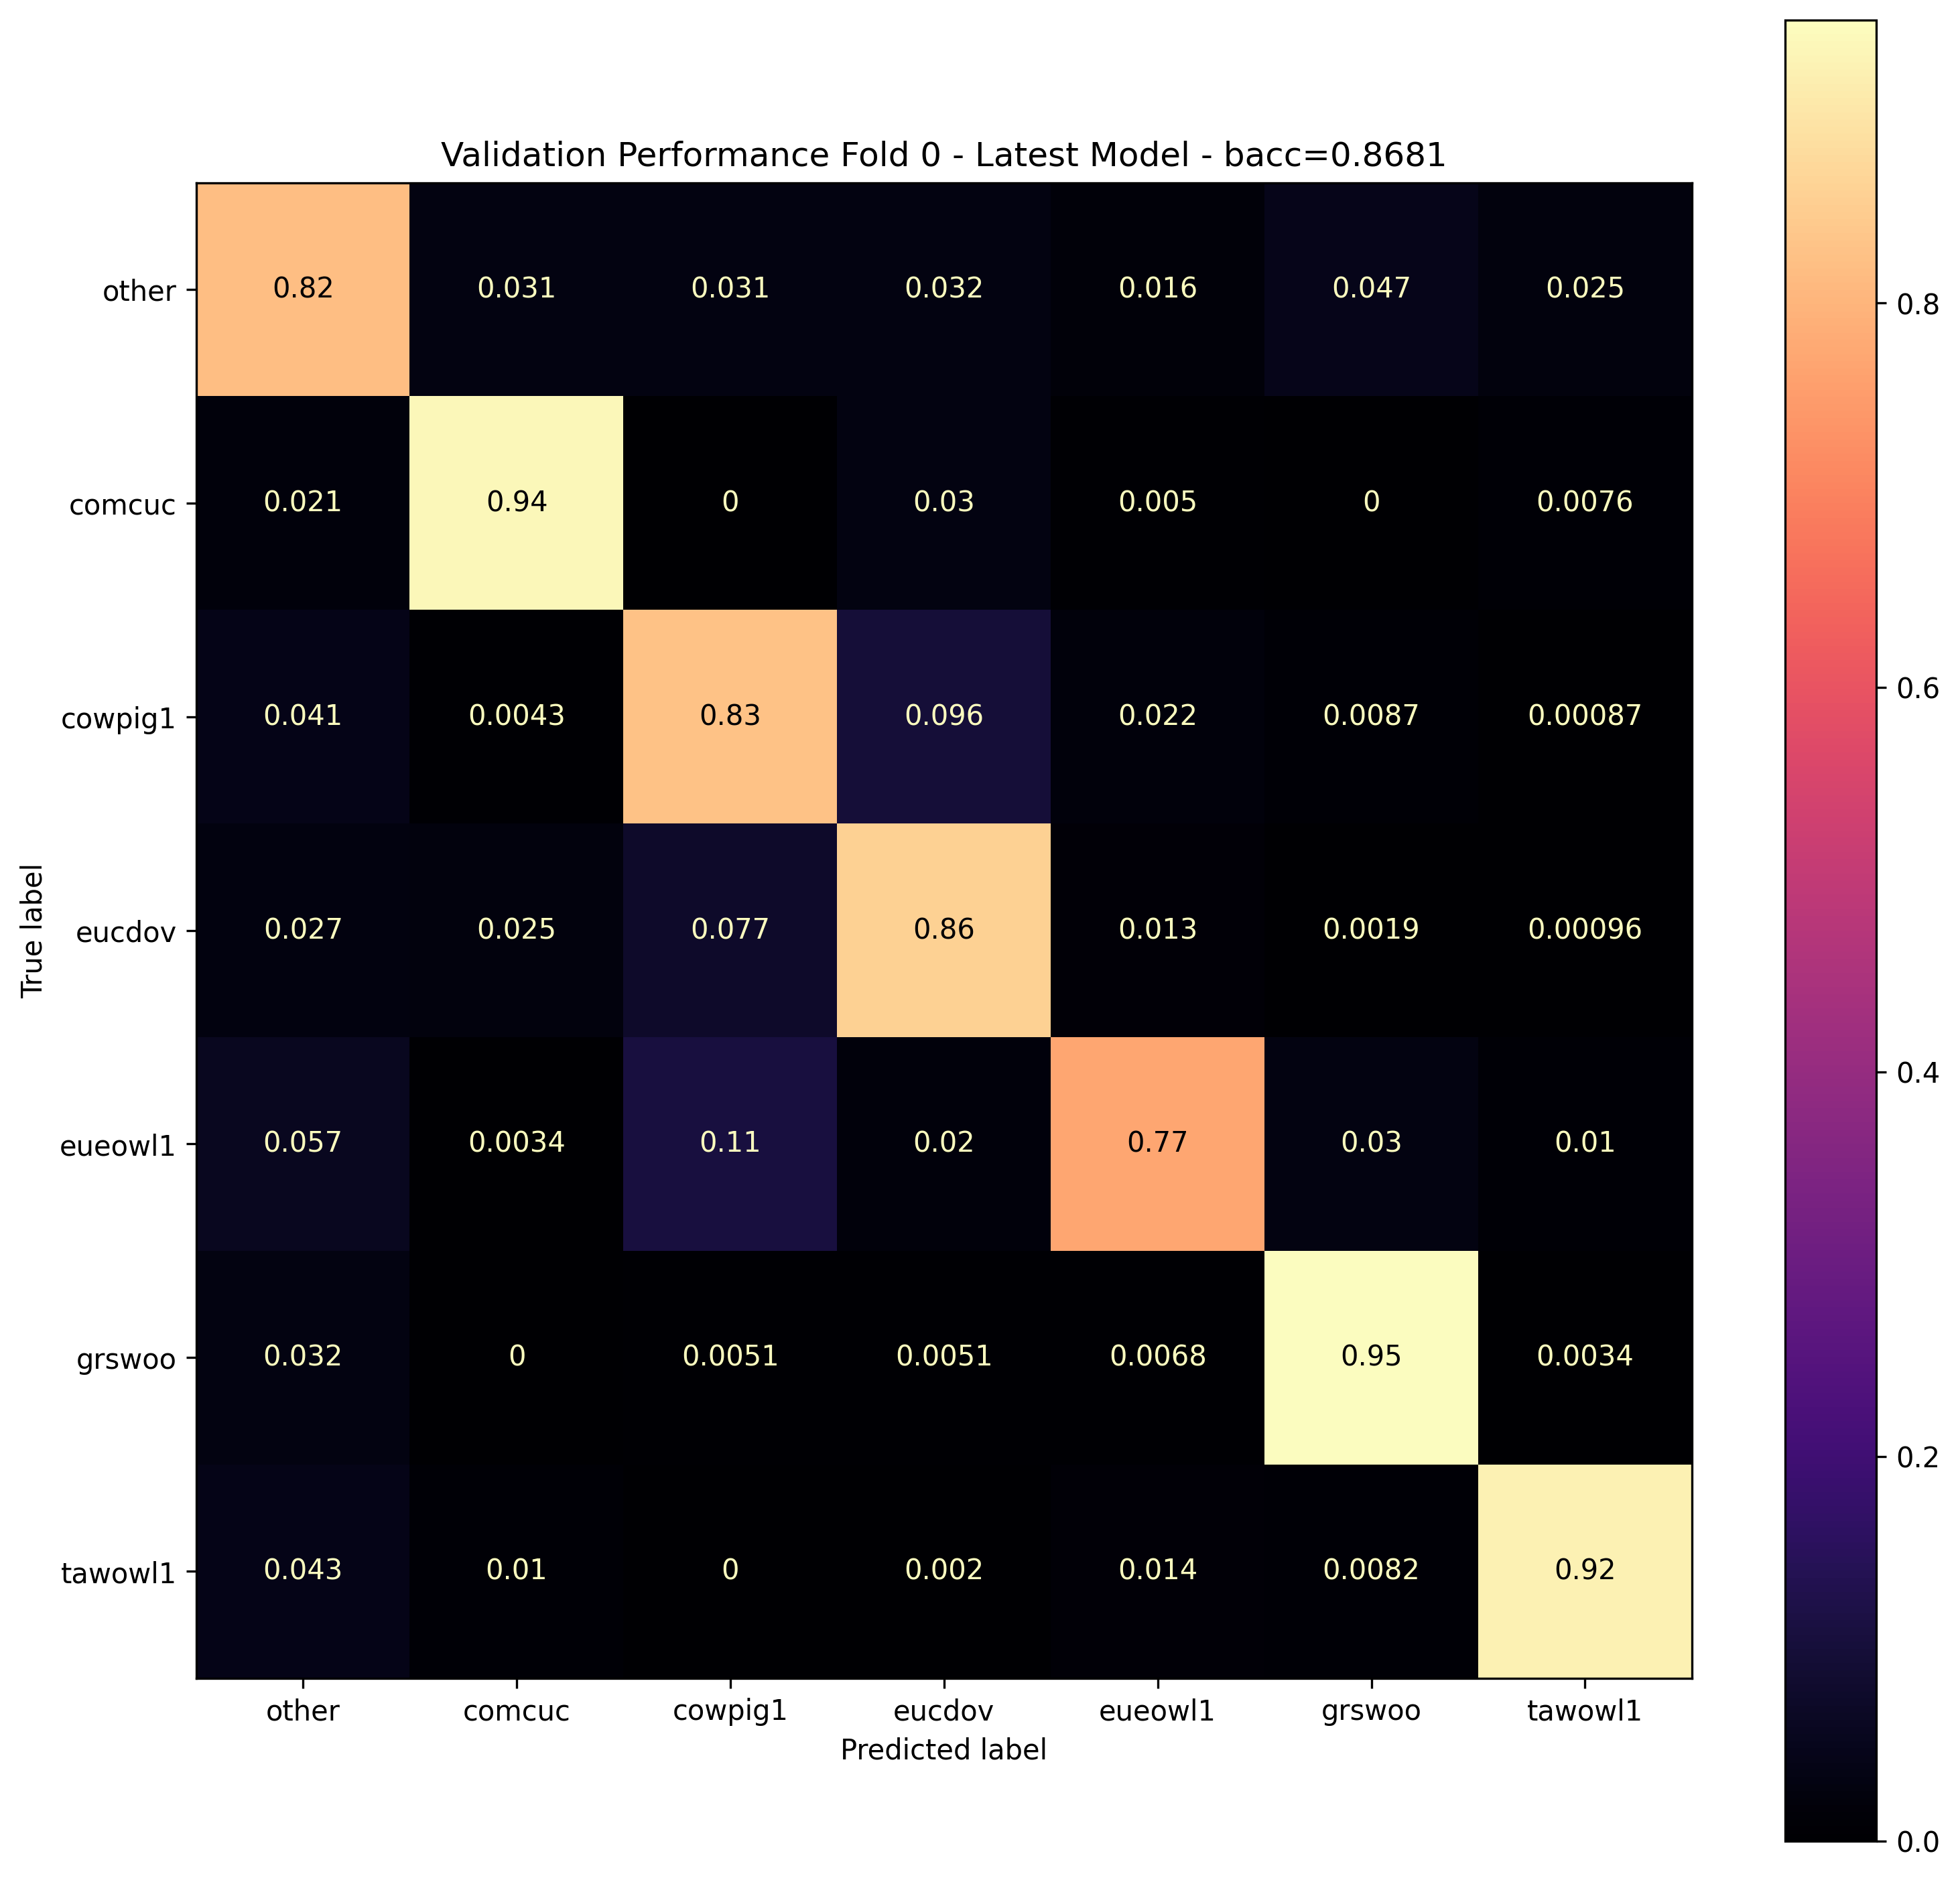

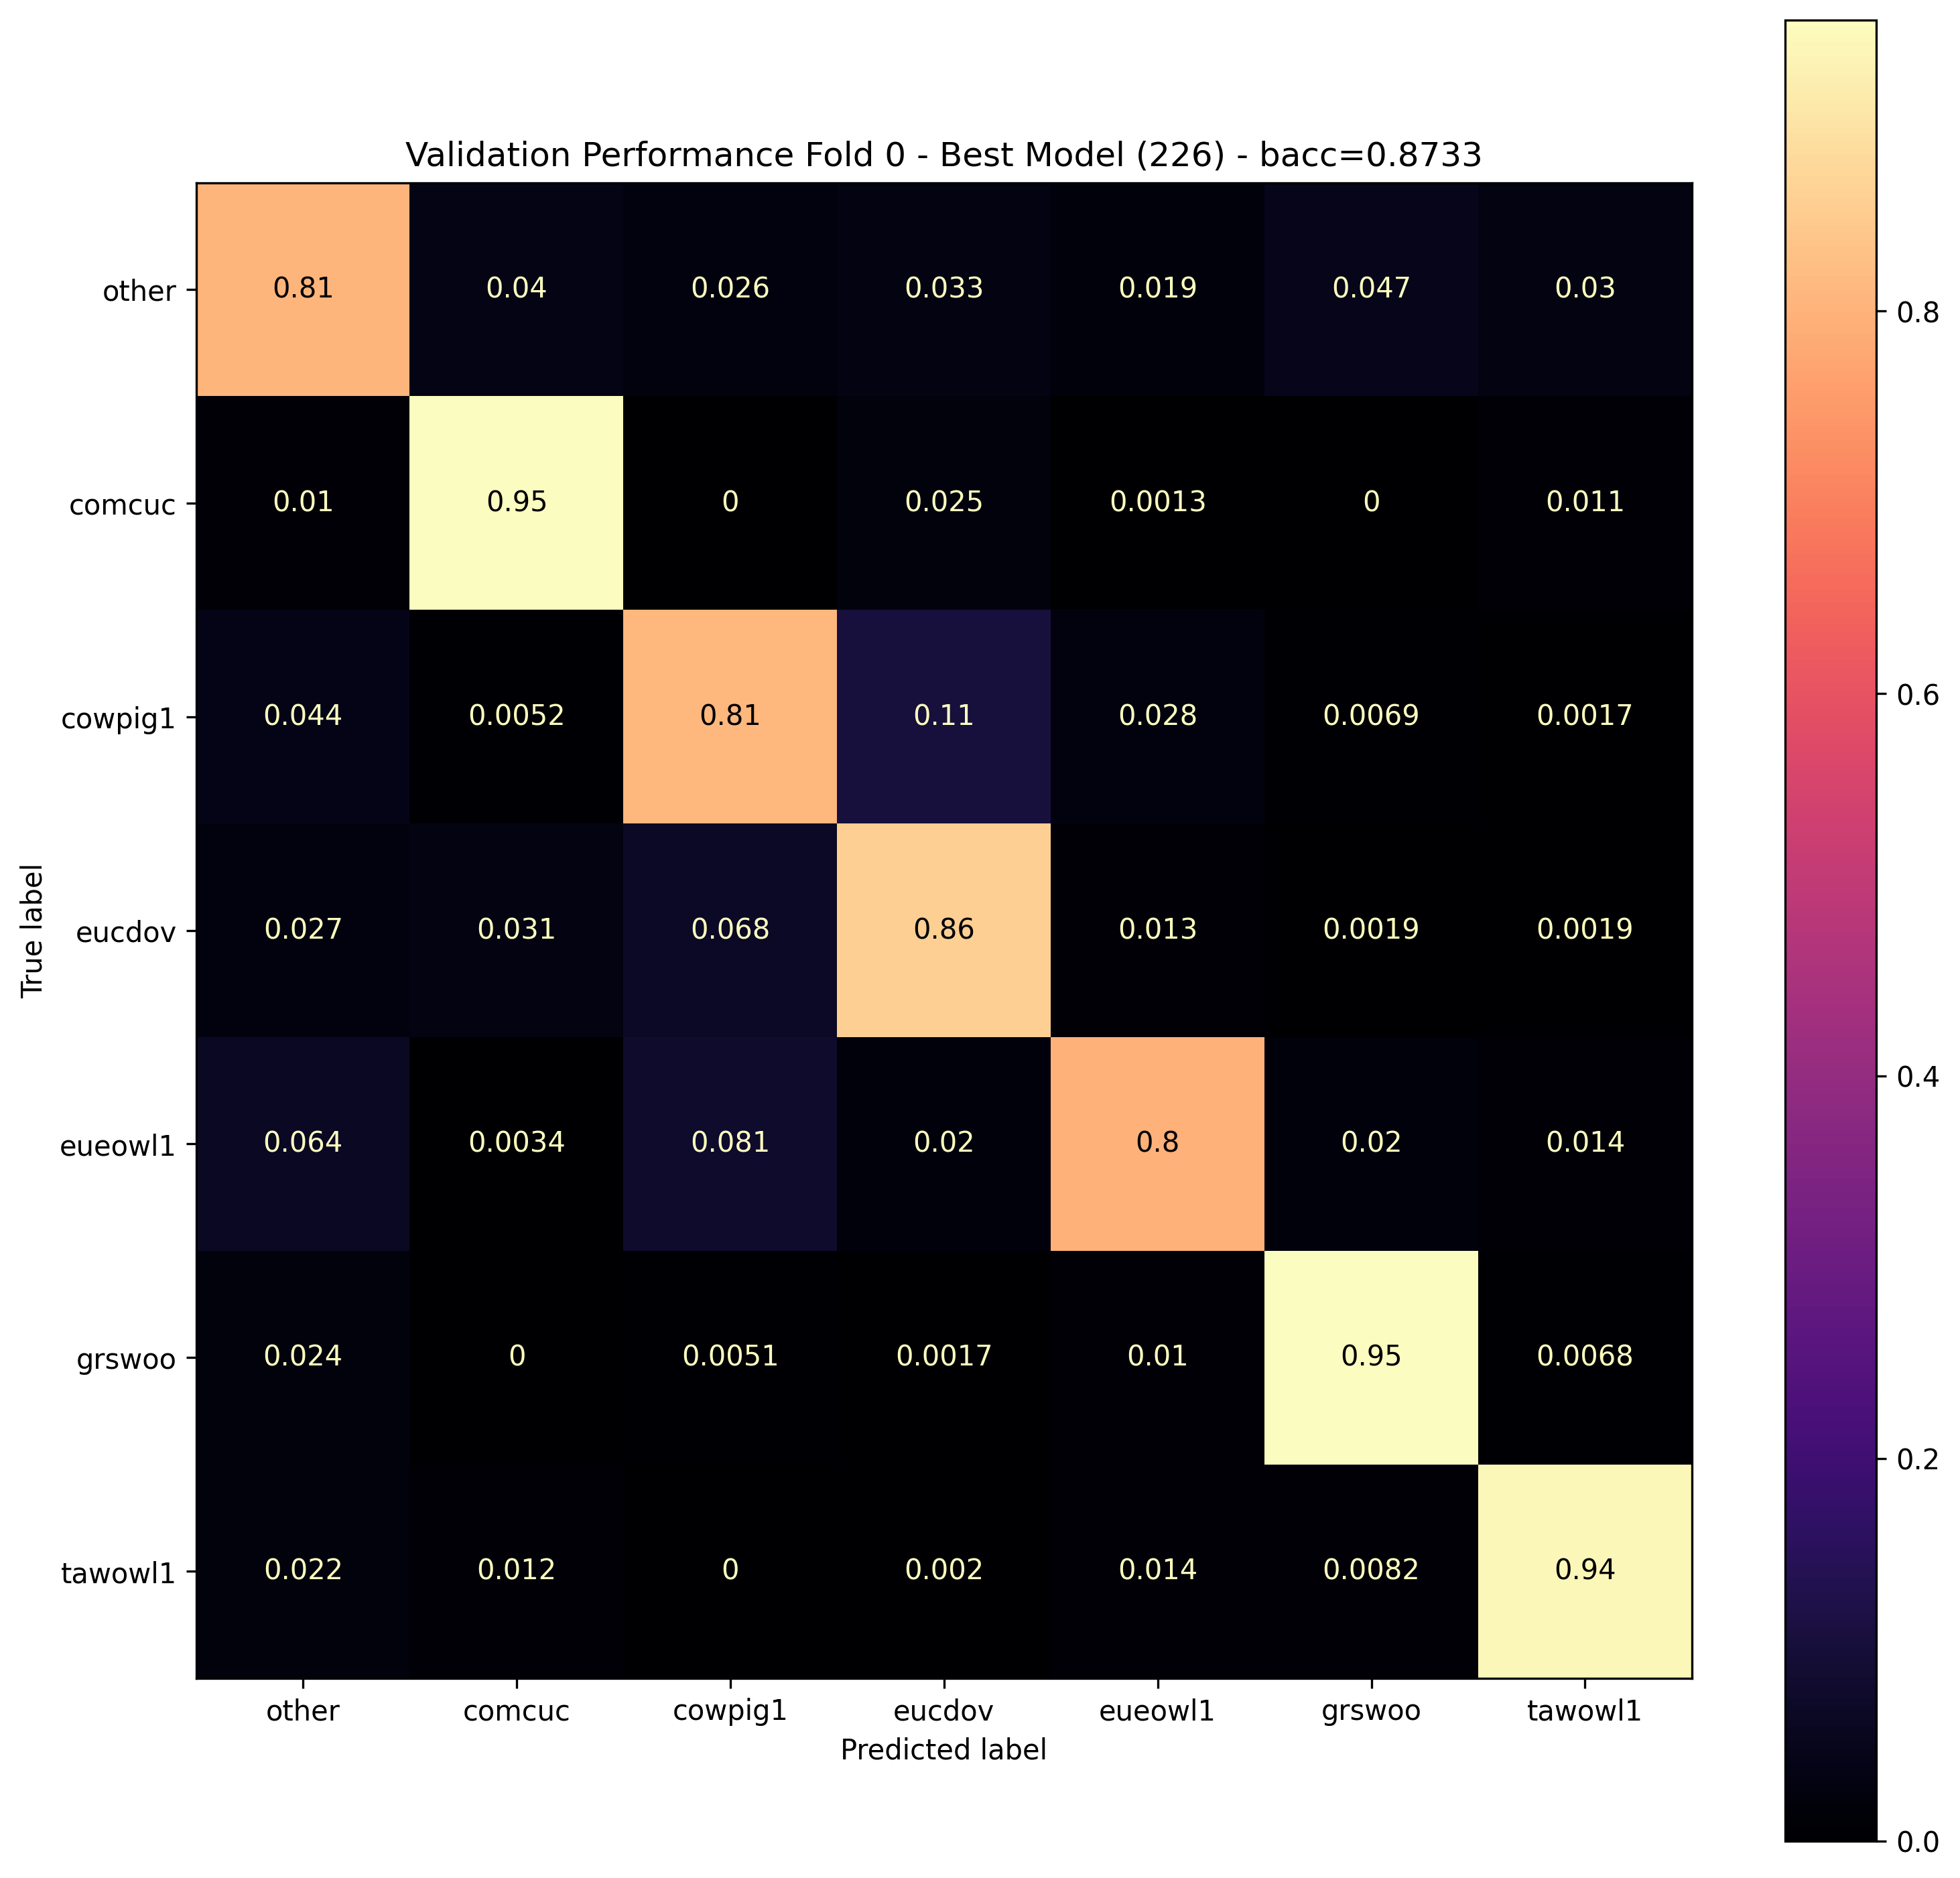

Executing CV for fold 1
Training fold 1
Training AttentionClassifier with 65823 parameters
train label counts = [74588, 5128, 7851, 7318, 1988, 4415, 3712]
loss weights = [0.74, 14.55, 6.33, 10.19, 37.52, 16.89, 20.09]
eval label counts = [10770, 705, 1103, 880, 336, 696, 510]
eval loss weights = [0.74, 15.28, 6.51, 12.24, 32.05, 15.47, 21.12]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  3521, acc = 0.033533, bacc = 0.143865
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000272, num_samples = 15000, num_correct =   510, acc = 0.034000, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000203, num_samples = 105000, num_correct =  3581, acc = 0.034105, bacc = 0.142955
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000272, num_samples = 15000, num_correct =   446, acc = 0.029733, bacc = 0.138275
Training Epoch   3/300: lr = 1.00E-03, epoch =     3, avg_loss = 0.000203, num_sam

In [ ]:
set_random_seed(43)

cv_training_hyper_parameters = create_training_hyper_parameters(
    num_epochs=300,
    initial_lr=1e-3,
    lr_scheduler_milestones=[30, 100, 250],
    lr_scheduler_gamma=0.75,
)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_attention_classifier_with_cv(
    hyper_parameters, 
    cv_training_hyper_parameters, 
    combined_ds,
    8,
    device,
    save_models=None
)


## Metrics ##

cv_final_epoch_avg_train_metrics, cv_final_epoch_avg_evaluation_metrics = calculate_average_metrics_for_final_epoch_of_folds(cv_folds_metrics)
print(f'{cv_final_epoch_avg_train_metrics      = }')
print(f'{cv_final_epoch_avg_evaluation_metrics = }')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

## Final Train/Test

In [ ]:
set_random_seed(42)

final_training_hyper_parameters = create_training_hyper_parameters(
    epoch_multiplier=1.25, 
    lr_multiplier=0.55
)

data_train_normalized, data_test_normalized, normalization_scaler = normalize_data(data_train, data_test)

latest_attention_classifier, training_run_metrics, best_attention_classifier, best_metrics = train_attention_classifier(
    hyper_parameters, 
    final_training_hyper_parameters, 
    NumpyDataset(data_train_normalized, labels_train),
    NumpyDataset(data_test_normalized, labels_test),
    device
)

test_loader = create_data_loader(data_test_normalized, labels_test)

test_metrics_latest_model = evaluate_attention_classifier(
    latest_attention_classifier, 
    test_loader, 
    device, 
    show_confmat=True,
    confmat_title=f'Test Set Performance - Latest Model'
)
test_metrics_best_model = evaluate_attention_classifier(
    best_attention_classifier, 
    test_loader, 
    device, 
    show_confmat=True,
    confmat_title=f'Test Set Performance - Best Model'
)

print(f'{training_run_metrics[-1][0] = }')
print(f'{test_metrics_latest_model   = }')
print(f'{test_metrics_best_model     = }')

# Plots

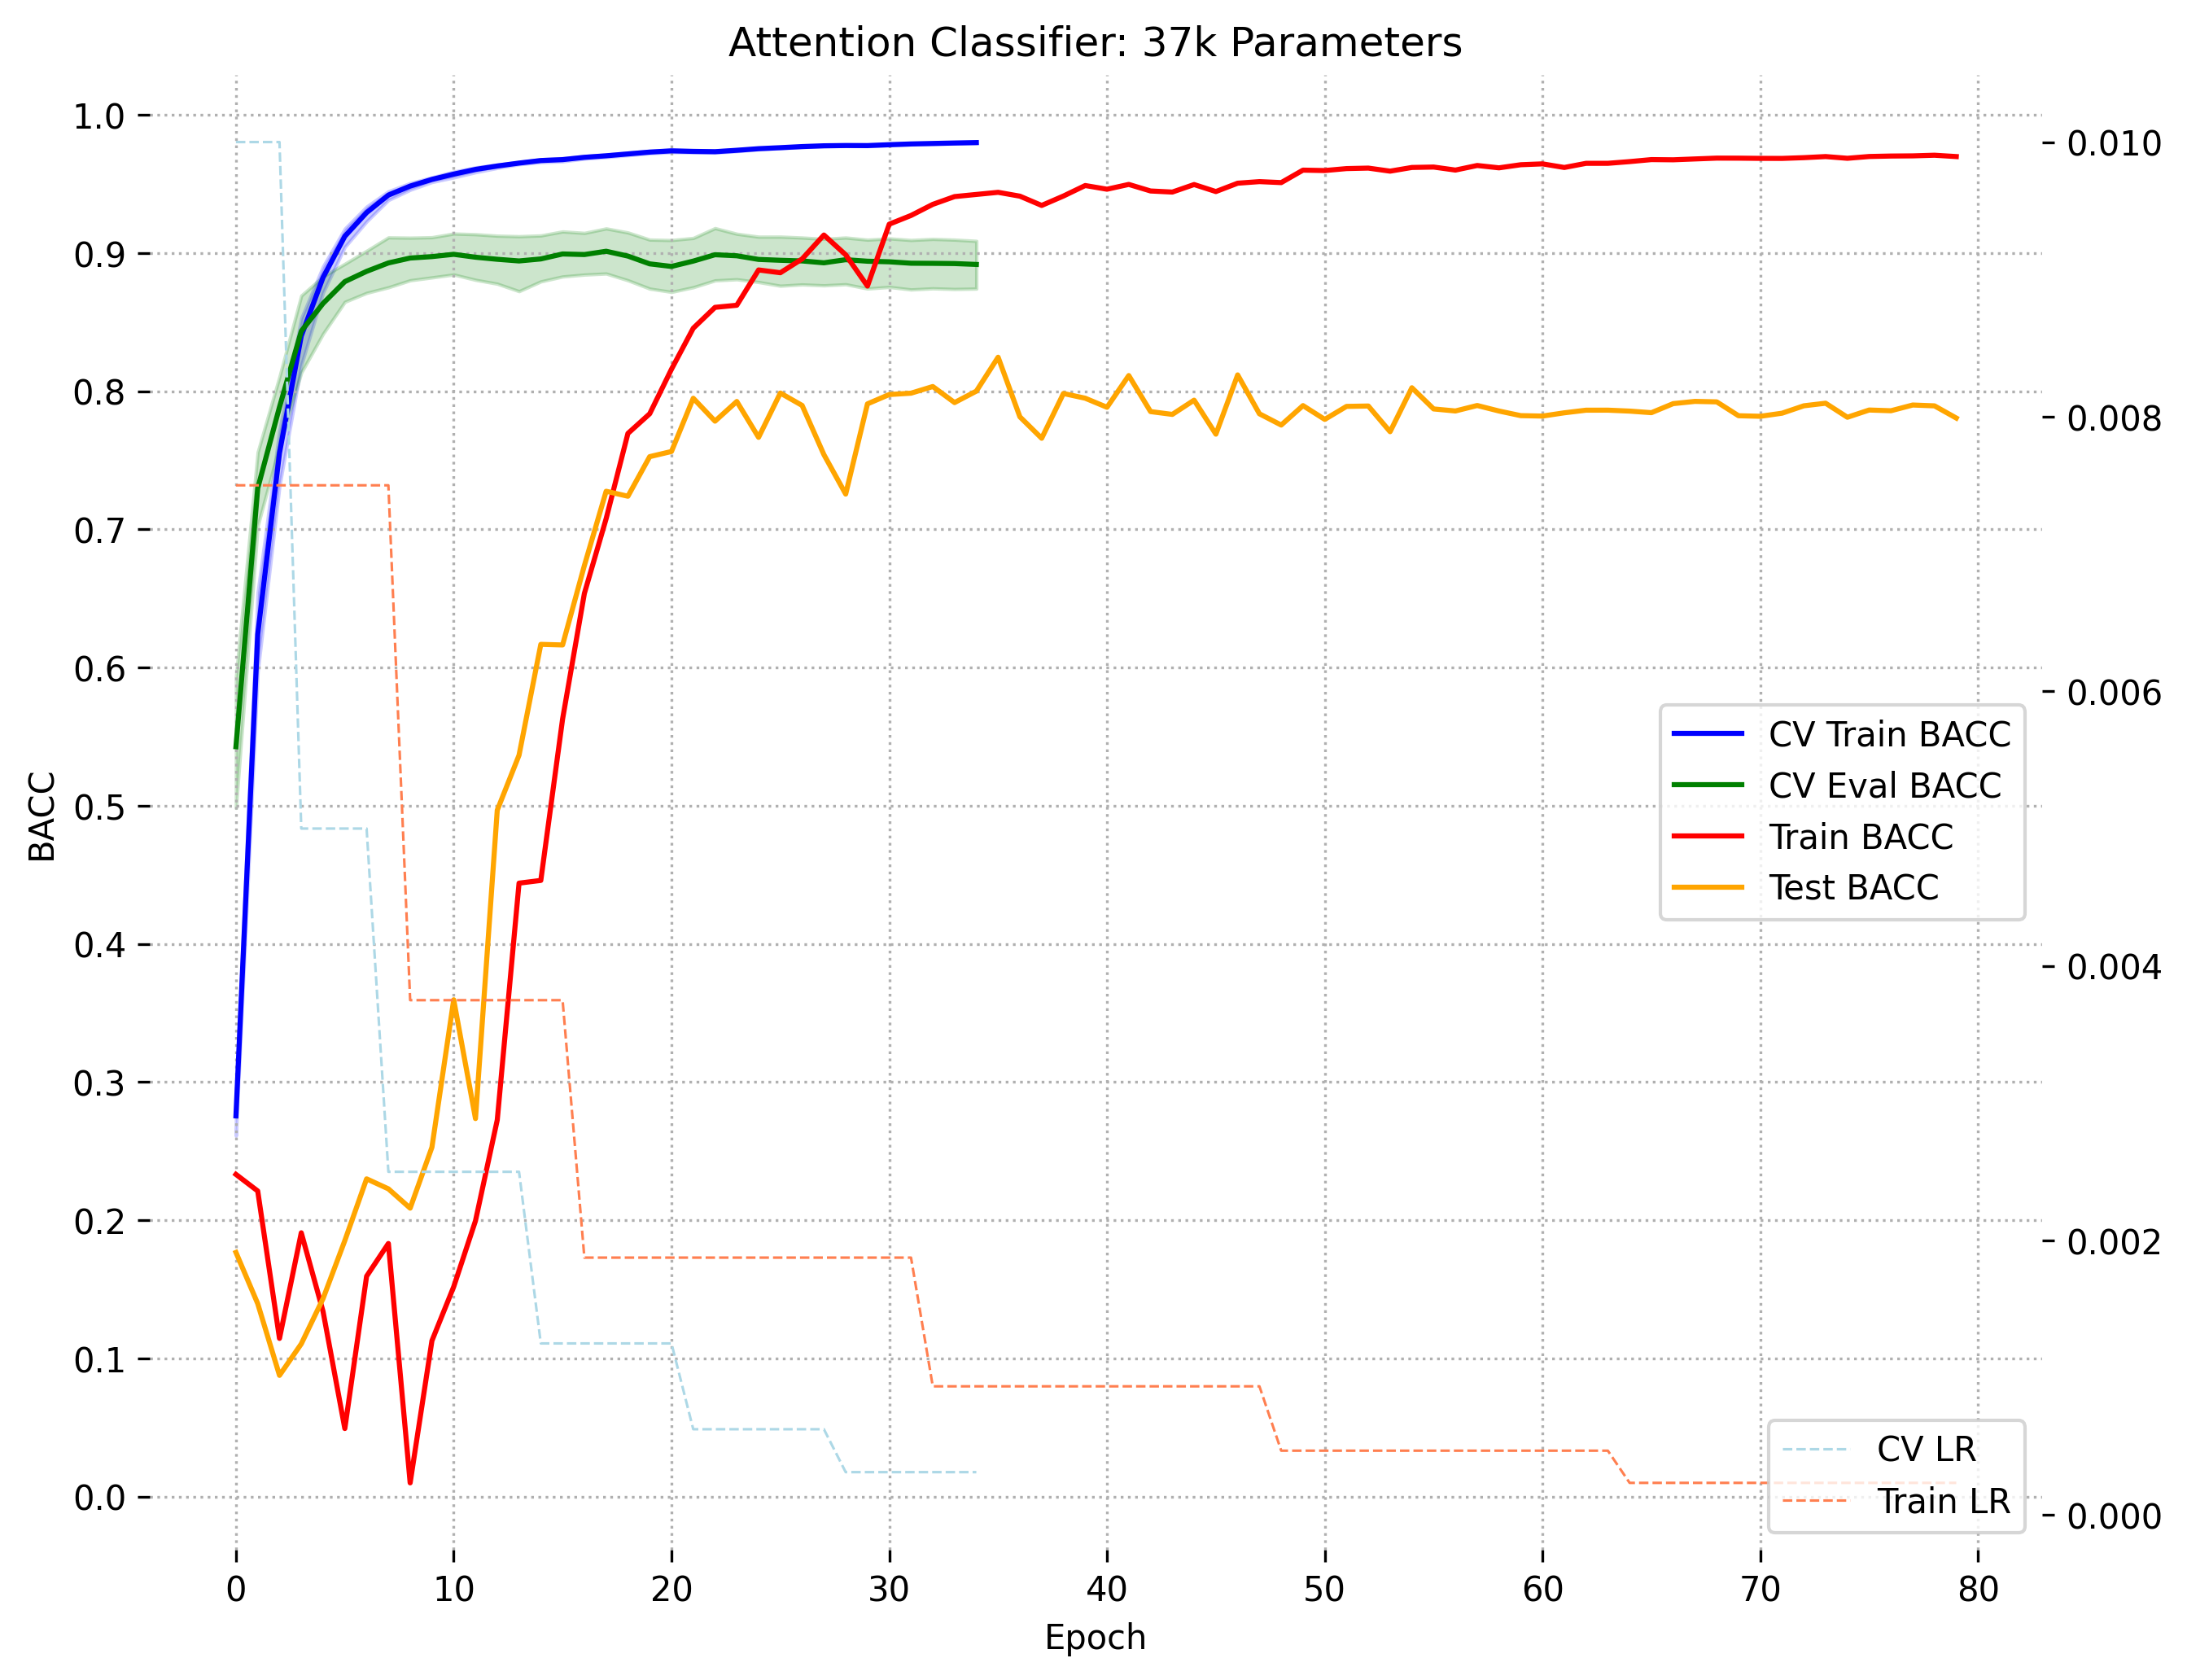

In [59]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    final_train_epoch_range = np.arange(0, final_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])

    ax.plot(final_train_epoch_range, list(map(lambda m: m[0].bacc, training_run_metrics)), label='Train BACC', c='red')
    ax.plot(final_train_epoch_range, list(map(lambda m: m[1].bacc, training_run_metrics)), label='Test BACC', c='orange')
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)
    twin_ax.plot(final_train_epoch_range, create_lrs_over_epochs(final_training_hyper_parameters), label='Train LR', c='coral', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

plot_baccs_over_epochs('Attention Classifier: 37k Parameters')

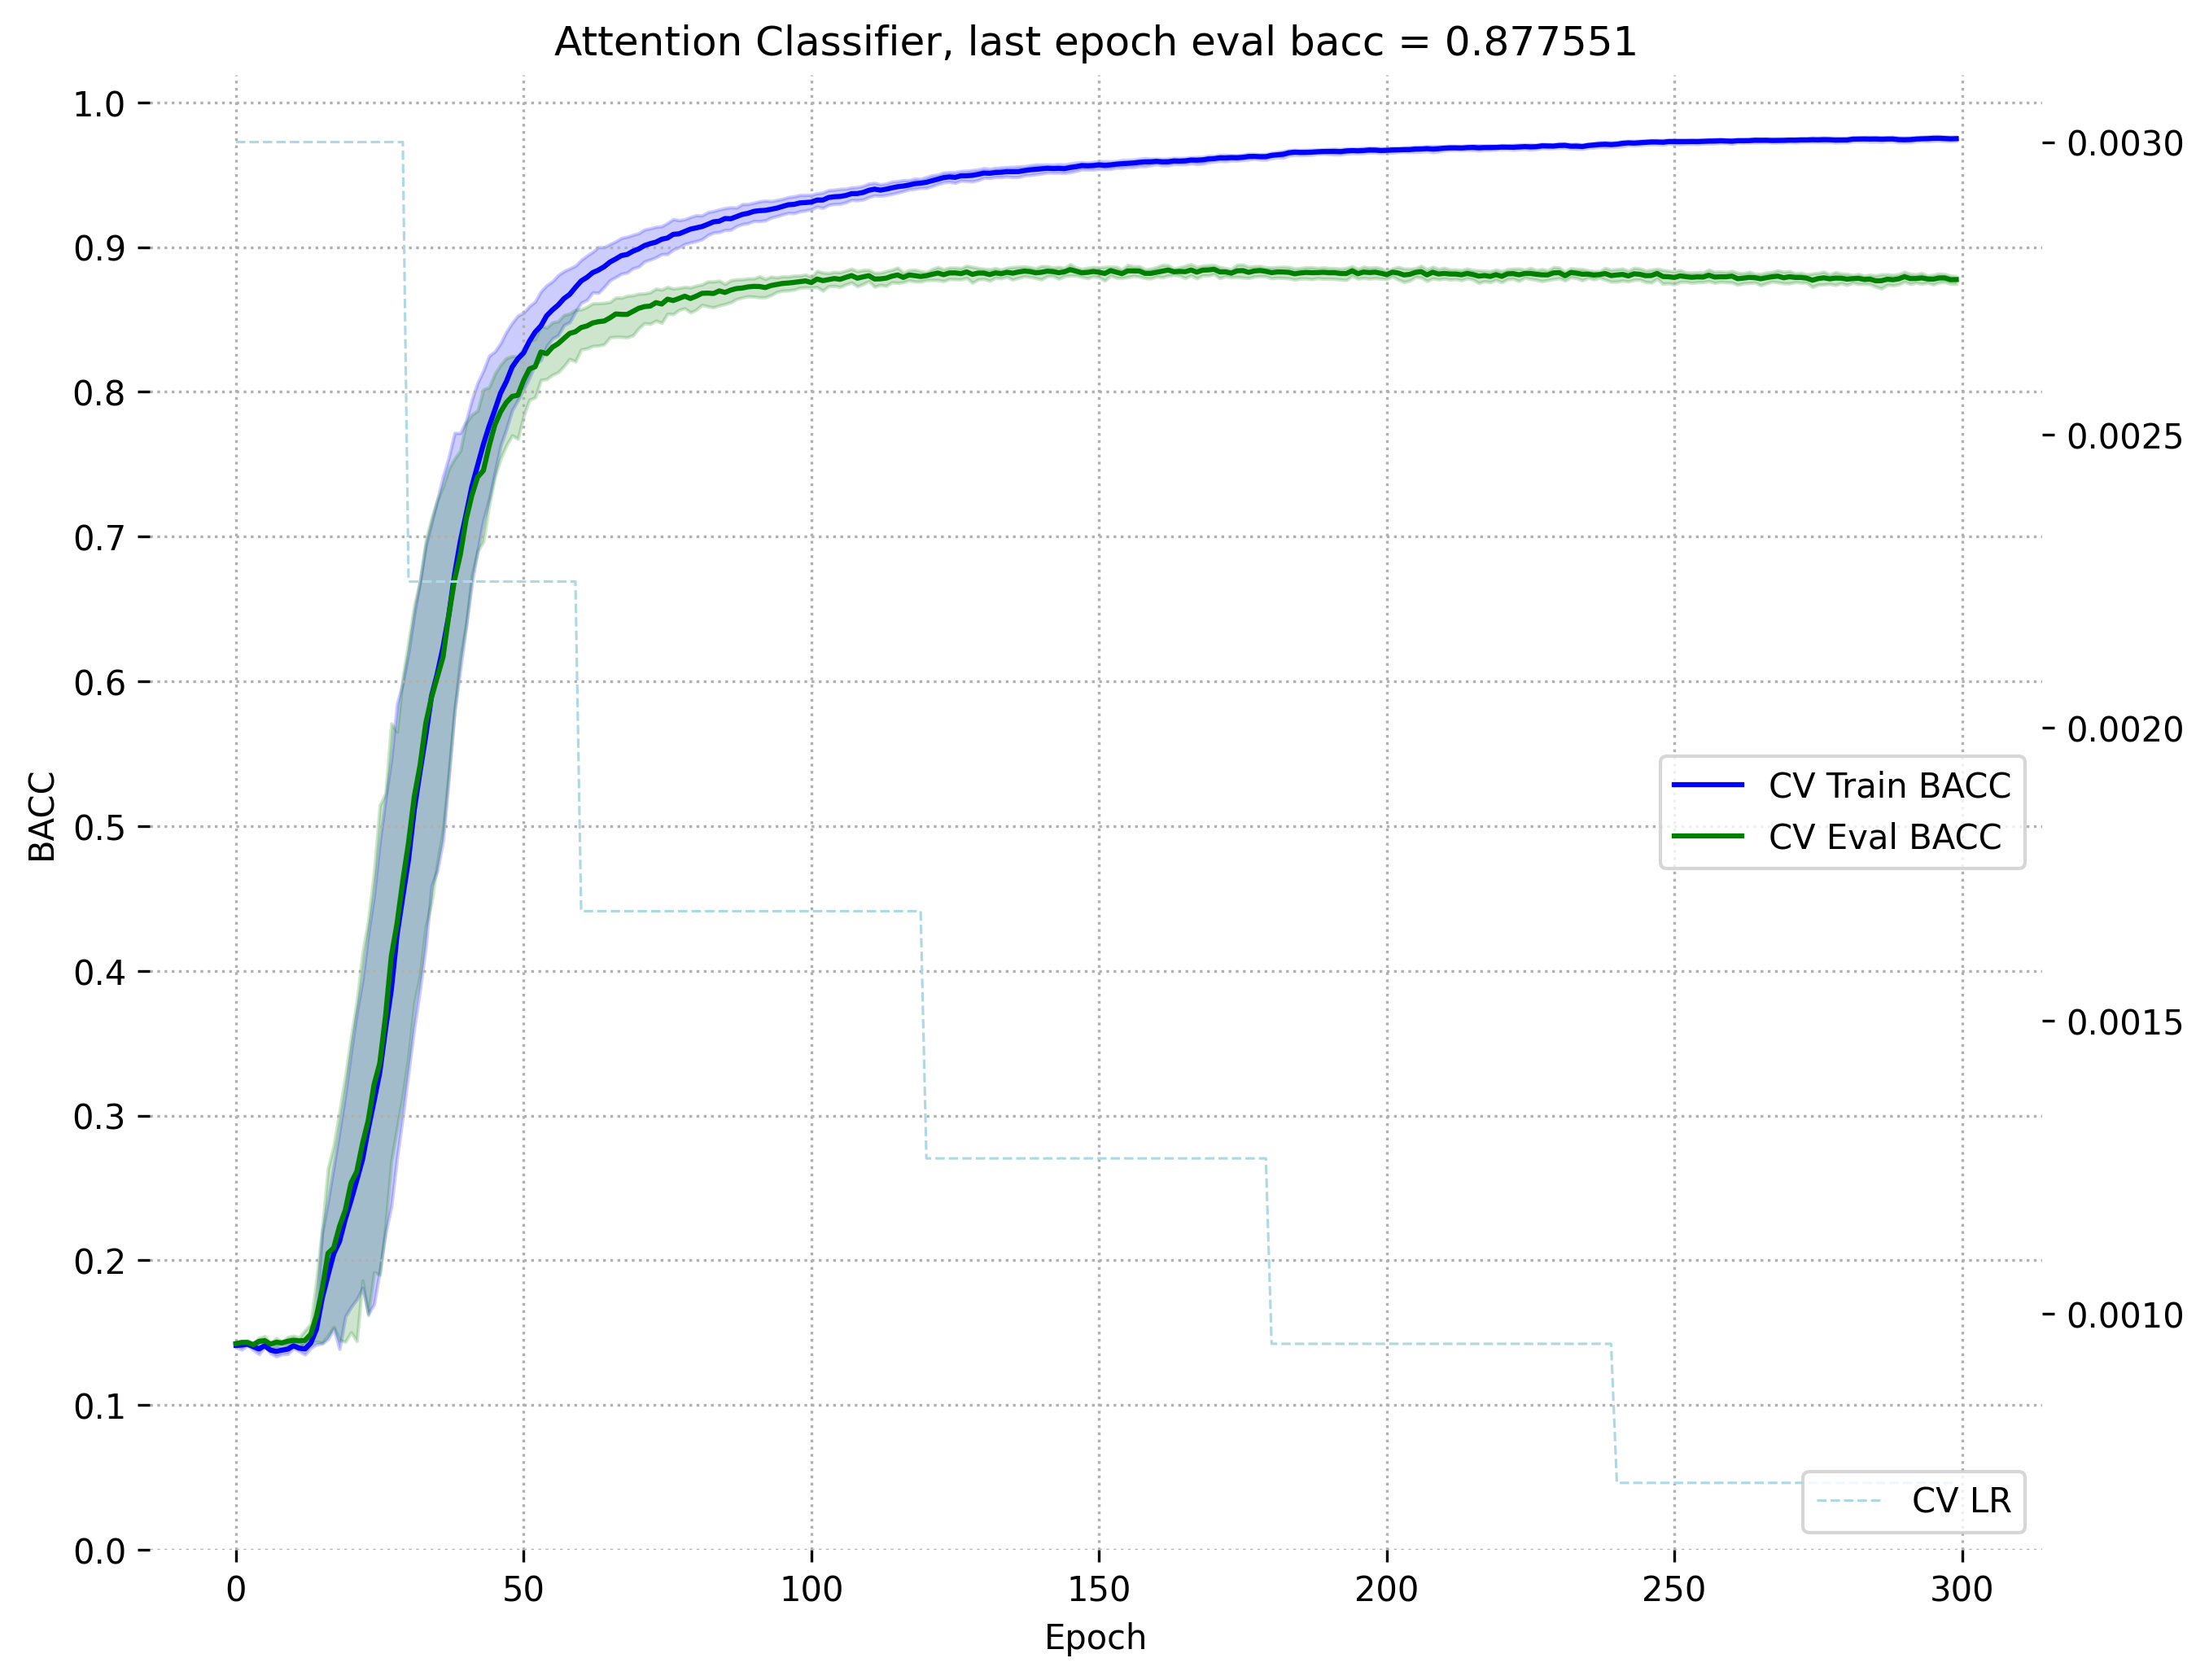

In [22]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')

In [ ]:
cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']

# Challenge

In [26]:
challenge_data = load_challenge_data()
challenge_data.shape

(16, 3000, 548)

In [28]:
def predict():
    predictions_list: list[np.ndarray] = []
    for latest_model, best_model, normalization_scaler in cv_models_with_scalers:
        predictions_list.append(
            torch.argmax(
                predict_for_challenge(challenge_data, best_model, normalization_scaler, device), 
                dim=2
            ).detach().cpu().numpy()
        )
    return np.moveaxis(np.array(predictions_list), 0, -1)

predictions = predict()
predictions.shape

(16, 3000, 8)

In [35]:
def vote():
    n_sequences, sequence_length, n_models = predictions.shape
    
    voting_results = np.zeros((n_sequences, sequence_length)).astype(int)
    
    voting_weights = np.array([model_metrics[1].bacc for model_metrics in best_models_metrics])
    voting_weights -= 0.87
    voting_weights = voting_weights ** 1.1
    voting_weights /= voting_weights.max()
    
    print(f'voting_weights = {str([round(w, 2) for w in voting_weights])}')

    for sequence_nr in range(n_sequences):
        for fragment_nr in range(sequence_length):
            
            votes = [0.0] * n_models
            
            for model_nr in range(n_models):
                votes[predictions[sequence_nr, fragment_nr, model_nr]] += voting_weights[model_nr]
            
            voting_results[sequence_nr, fragment_nr] = np.argmax(votes)
    
    return voting_results

voting_results = vote()
voting_results

voting_weights = [1.0, 0.35, 0.68, 0.83, 0.77, 0.87, 0.36, 0.72]


array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
save_results_to_csv(voting_results, 'submissions/challenge_submission_TODO.csv')

NameError: name 'voting_results' is not defined

In [14]:
saved_predictions = load_results_from_csv('submissions/challenge_submission_original_ac score=10861.csv')

fixed_labels = fix_labels_information_gain(
    labels=saved_predictions, 
    window_size=32, 
    window_overlap=9, 
    splitting_point_window_shrink=5,
    split_at_0_only=True,
    information_gain_threshold=0.1,
)
save_results_to_csv(fixed_labels, 'submissions/challenge_submission_original_ac_fixed score=TBD.csv')

Fixing label sequences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.67it/s]
